In [16]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.typing import NDArray
from PIL import Image
from skimage.util import view_as_windows
from google.colab import files

In [2]:
# Przykładowe funkcje
def f1(x):
  return np.sin(x)

def f2(x):
  return np.sin(1/x)

def f3(x):
  return np.sign(np.sin(8*x))

In [3]:
# Interpolacja 1D
def interpolacja1d(x_interpolowany: np.array, x_mierzony: np.array, y_mierzony: np.array, kernel: callable) -> np.array:
  return y_mierzony @ [kernel((x_interpolowany-offset)/(x_mierzony[1]-x_mierzony[0])) for offset in x_mierzony]

# dla kazdej wartości w wektorze x_mierzony wykonuje funkcje kernela która puźniej jest mnorzona macierzowo z y mierzony

In [4]:
# Funkcje jądrowe

def kernel_sample_hold(t: np.array) -> np.array:
    # kernel interpolacji typu Sample hold
    return (t >= 0) * (t < 1)

def kernel_najblizszy_sasiad(t: np.array) -> np.array:
    # kernel interpolacji typu metoda najbliższego sąsiada
    return (t >= -1/2) * (t < 1/2)

def kernel_liniowy(t: np.array) -> np.array:
    # kernel interpolacji liniowej
    return (np.abs(t) <= 1) * (1-np.abs(t))

def kernel_sin(x: np.array) -> np.array:
    # kernel z interpolacją z sinusem
    return (np.abs(x) < np.inf) * np.sinc(x)



In [5]:
# Funkcja wyliczająca mse
def mse(y_true, y_pred):
    return  np.mean((y_true - y_pred)*(y_true - y_pred))

Mean Squared Error (MSE) : 0.36913764


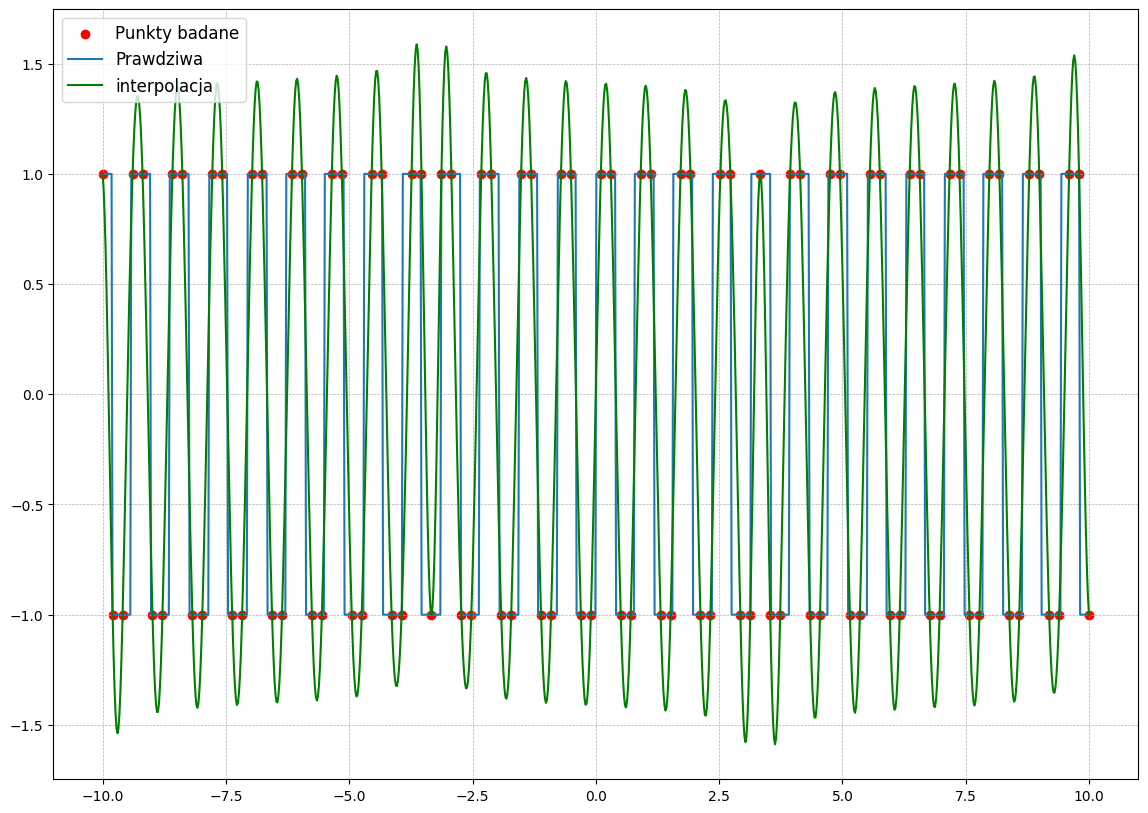

In [6]:
ils = 100
przewidywany = ils*10
x = np.linspace(-10, 10, ils)
x_przewidywany = np.linspace(-10, 10, przewidywany)
y = f3(x) #przypisujemy y wartosci jakiejś funkcji
y_prawdziwy = f3(x_przewidywany)
y_interpolowany = interpolacja1d(x_interpolowany=x_przewidywany, x_mierzony=x, y_mierzony=y, kernel=kernel_sin)



plt.figure(figsize=(14, 10))

plt.scatter(x, y, color='red', label='Punkty badane')
plt.plot(x_przewidywany, y_prawdziwy, label='Prawdziwa')
plt.plot(x_przewidywany, y_interpolowany, color='green', label='interpolacja')
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show



print(f"Mean Squared Error (MSE) : {mse(y_prawdziwy, y_interpolowany):.8f}")

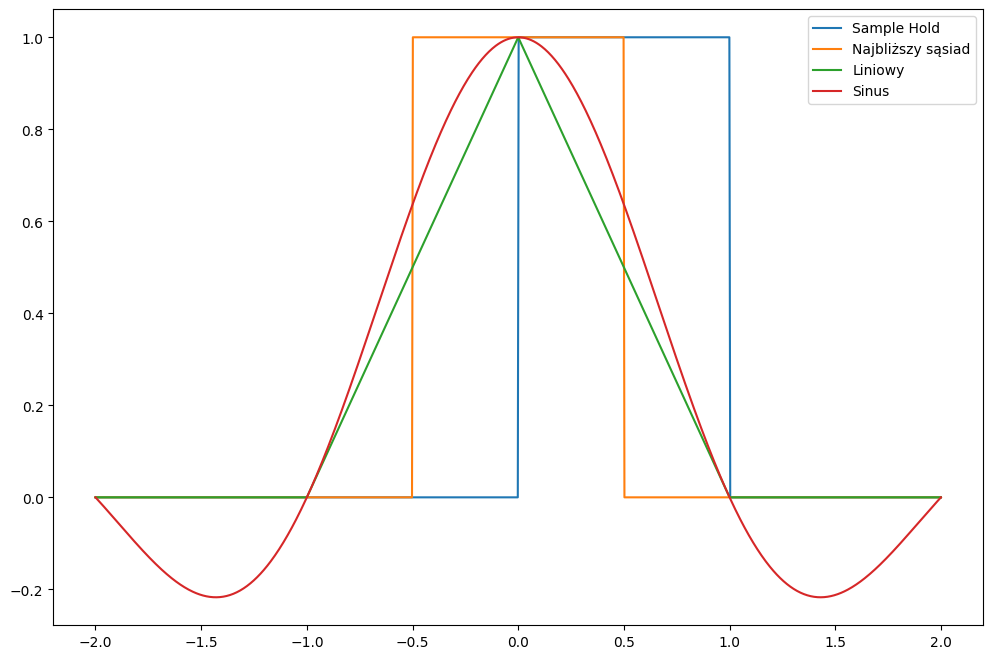

In [7]:
x = np.linspace(-2, 2, 1000)

plt.figure(figsize=[12, 8])
plt.plot(x, kernel_sample_hold(x))
plt.plot(x, kernel_najblizszy_sasiad(x))
plt.plot(x, kernel_liniowy(x))
plt.plot(x, kernel_sin(x))


plt.legend(["Sample Hold", "Najbliższy sąsiad", "Liniowy", "Sinus"])


In [8]:
#ładowanie obrazu
def load_image(file_path: str) -> NDArray:
    """
    Wczytuje obraz w skali szarości z pliku.

    :param file_path: ścieżka do pliku obrazu
    :return: obraz jako 2D NDArray
    """
    with Image.open(file_path) as img:
        return np.array(img.convert("L"))

In [9]:
#zapisywanie obrazu
def save_image(image: NDArray, file_path: str):
    """
    Zapisuje obraz do pliku.

    :param image: obraz jako 2D NDArray
    :param file_path: ścieżka do pliku wynikowego
    """
    img = Image.fromarray(np.clip(image, 0, 255).astype(np.uint8))
    img.save(file_path)

In [10]:
#funkcje jadrowe 2d
def kernel2d_sample_hold(t: NDArray) -> NDArray:
    x, y = t[:, 0], t[:, 1]
    return (x >= 0) * (x < 1) * (y >= 0) * (y < 1)


def kernel2d_najblizszy_sasiad(t: NDArray) -> NDArray:
    x, y = t[:, 0], t[:, 1]
    return (x >= (-1 / 2)) * (x < (1 / 2)) * (y >= (-1 / 2)) * (y < (1 / 2))


def kernel2d_liniowy(t: NDArray) -> NDArray:
    x, y = t[:, 0], t[:, 1]

    return ((1 - np.abs(x)) * (1 - np.abs(y))) * (np.abs(x) < 1) * (np.abs(y) < 1)


def kernel2d_sin(t: NDArray) -> NDArray:
    x, y = t[:, 0], t[:, 1]

    return  (np.abs(x) < np.inf) *  (np.abs(y) < np.inf) * (np.sinc(x) * np.sinc(y))

In [11]:
#upsampling przy uzyciu interpolacji
def image_interpolate2d(image: NDArray, ratio: int, kernel: callable) -> NDArray:


    # Rozmiar jądra
    w = 1.0

    # Rozmiar obrazu wynikowego
    target_shape = (image.shape[0] * ratio, image.shape[1] * ratio)

    # Siatka współrzędnych obrazu wejściowego
    image_grid_x, image_grid_y = np.meshgrid(
        np.arange(image.shape[1]), np.arange(image.shape[0])
    )
    image_grid = np.stack([image_grid_x.ravel(), image_grid_y.ravel()], axis=1)

    # Siatka współrzędnych dla interpolacji
    interpolate_grid_x, interpolate_grid_y = np.meshgrid(
        np.linspace(0, image.shape[1] - 1, target_shape[1]),
        np.linspace(0, image.shape[0] - 1, target_shape[0])
    )
    interpolate_grid = np.stack([interpolate_grid_x.ravel(), interpolate_grid_y.ravel()], axis=1)

    interpolated_image = np.zeros(target_shape)
    for point, value in zip(image_grid, image.ravel()):
        kernel_value = value * kernel((interpolate_grid-point)/w)
        interpolated_image += kernel_value.reshape(target_shape)

    return interpolated_image

In [15]:
def downsample(image: NDArray, kernel_size: int = 2) -> np.ndarray:

    # Tworzenie jądra uśredniającego
    kernel = np.ones((kernel_size, kernel_size)) / (kernel_size ** 2)

    # Tworzenie okien
    windows = view_as_windows(image, window_shape=(kernel_size, kernel_size), step=kernel_size)

    downsampled_image = np.zeros(windows.shape[:2])  # Inicjalizacja wynikowego obrazu
    for i in range(windows.shape[0]):
        for j in range(windows.shape[1]):
            downsampled_image[i, j] = np.sum(windows[i, j] * kernel)  # Operacja splotu

    return downsampled_image


In [18]:
print("Załaduj obraz do Colab")
uploaded = files.upload()  # Użytkownik przesyła plik

for file_name in uploaded.keys():
    print(f"Wczytywanie pliku: {file_name}")
    input_image = load_image(file_name)

    normal_file = "normal_image.png"
    upsampled_file = "upsampled_image.png"
    downsampled_file = "downsampled_image.png"
    weird_file = "weird_image.png"
    upsampled_image = image_interpolate2d(input_image, ratio=2, kernel=kernel2d_sin)
    downsampled_image = downsample(input_image, 2)
    weird_image = downsample(upsampled_image, 2)

    save_image(weird_image, weird_file)
    save_image(downsampled_image, downsampled_file)
    save_image(upsampled_image, upsampled_file)
    save_image(input_image, normal_file)

    # Pobranie pliku wynikowego
    files.download(weird_file)
    files.download(downsampled_file)
    files.download(upsampled_file)
    files.download(normal_file)

Załaduj obraz do Colab


Saving imresizer-1737243224899.jpg to imresizer-1737243224899 (2).jpg
Wczytywanie pliku: imresizer-1737243224899 (2).jpg


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>